# Step 1. Dataset 내려받기

이번에는 tensorflow_datasets 에 포함된 tf_flowers 데이터를 사용해 보겠습니다. tf_flowers 데이터에 대한 정보는 다음에서 확인해볼 수 있습니다.

tfds.load를 활용하여 데이터셋을 다운받으세요.

In [1]:
## warning message
import warnings
warnings.filterwarnings("ignore")

print("완료!")

완료!


In [2]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [3]:
import tensorflow_datasets as tfds

tfds.__version__

'4.4.0'

In [4]:
(raw_train, raw_validation, raw_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /aiffel/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
# Dataset 확인
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


# Step 2. Dataset을 모델에 넣을 수 있는 형태로 준비하기

이미지를 모두 같은 크기로 formatting 한 후, train_batches, validation_batches, test_batches를 준비합니다.

In [8]:
## image size 통일
## 이미지 사이즈 통일
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [12]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [13]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# Step 3. 모델 설계하기

cats_vs_dogs 의 경우와 달리, tf_flowers 데이터셋에서는 class의 갯수가 5가지입니다. 모델 설계시 어느 부분이 달라질지에 유의해 주세요.

In [27]:
## 이미지 분류 대회 ILSVRC, 데이터셋 ImageNet
## VGG16 가져오고, 모델 구조 확인
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')
# base_model.trainable = False  # 사전 학습된 가중치를 고정합니다.

In [28]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [29]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [30]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [19]:
## global average pooling
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [20]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [22]:
## Tensorflow를 활용해 모델 구조 설계
# 모델 생성에 필요한 함수
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D


# dense layer에는 unit과 activation 2개의 매개변수만 사용해주세요.
# unit의 값은 위에서 global_average_layer를 통과했을 때의 값을 생각해보세요.
# 활성화 함수는 ReLU를 사용합니다.
dense_layer = Dense(units=1024, activation='relu')
# unit은 우리가 분류하고 싶은 class를 생각해보세요.
# 활성화 함수는 Softmax를 사용합니다.
prediction_layer = Dense(units=5, activation='softmax') # class의 갯수가 5개라서 변경

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 5)


In [31]:
## base_model은 학습을 시키지 않음.
## 학습 여부를 결정하는 trainable 변수를 False 지정
base_model.trainable = False

In [34]:
from tensorflow.keras import layers, models

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  layers.Dropout(0.5),
  prediction_layer
])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 15,245,125
Trainable params: 530,437
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
## 직접 compile 코드 작성
base_learning_rate = 0.0001
# [[YOUR CODE]] optimizer를 adam으로 바꿀 수 있을 것 같다.
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# Step 4. 모델 학습시키기

In [38]:
EPOCHS = 10 
# [[YOUR CODE]]
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 18s 141ms/step - loss: 1.4165 - accuracy: 0.4135 - val_loss: 1.1179 - val_accuracy: 0.6676
Epoch 2/10
92/92 [==============================] - 8s 80ms/step - loss: 1.0716 - accuracy: 0.6260 - val_loss: 0.9035 - val_accuracy: 0.7357
Epoch 3/10
92/92 [==============================] - 8s 80ms/step - loss: 0.9036 - accuracy: 0.6914 - val_loss: 0.7810 - val_accuracy: 0.7439
Epoch 4/10
92/92 [==============================] - 8s 81ms/step - loss: 0.8057 - accuracy: 0.7282 - val_loss: 0.7087 - val_accuracy: 0.7466
Epoch 5/10
92/92 [==============================] - 8s 82ms/step - loss: 0.7347 - accuracy: 0.7469 - val_loss: 0.6595 - val_accuracy: 0.7711
Epoch 6/10
92/92 [==============================] - 8s 81ms/step - loss: 0.6800 - accuracy: 0.7704 - val_loss: 0.6290 - val_accuracy: 0.7738
Epoch 7/10
92/92 [==============================] - 8s 80ms/step - loss: 0.6421 - accuracy: 0.7834 - val_loss: 0.6156 - val_accuracy: 0.7875
Epoch 8/10


# Step 5. 모델 성능 평가하기

모델 학습이 완료되었다면, 모델의 성능을 평가할 차례입니다.

모델이 학습된 과정을 그래프로도 그려보고, validation_batches나 test_batches에 있는 데이터에 대한 예측 결과도 확인해 보세요!

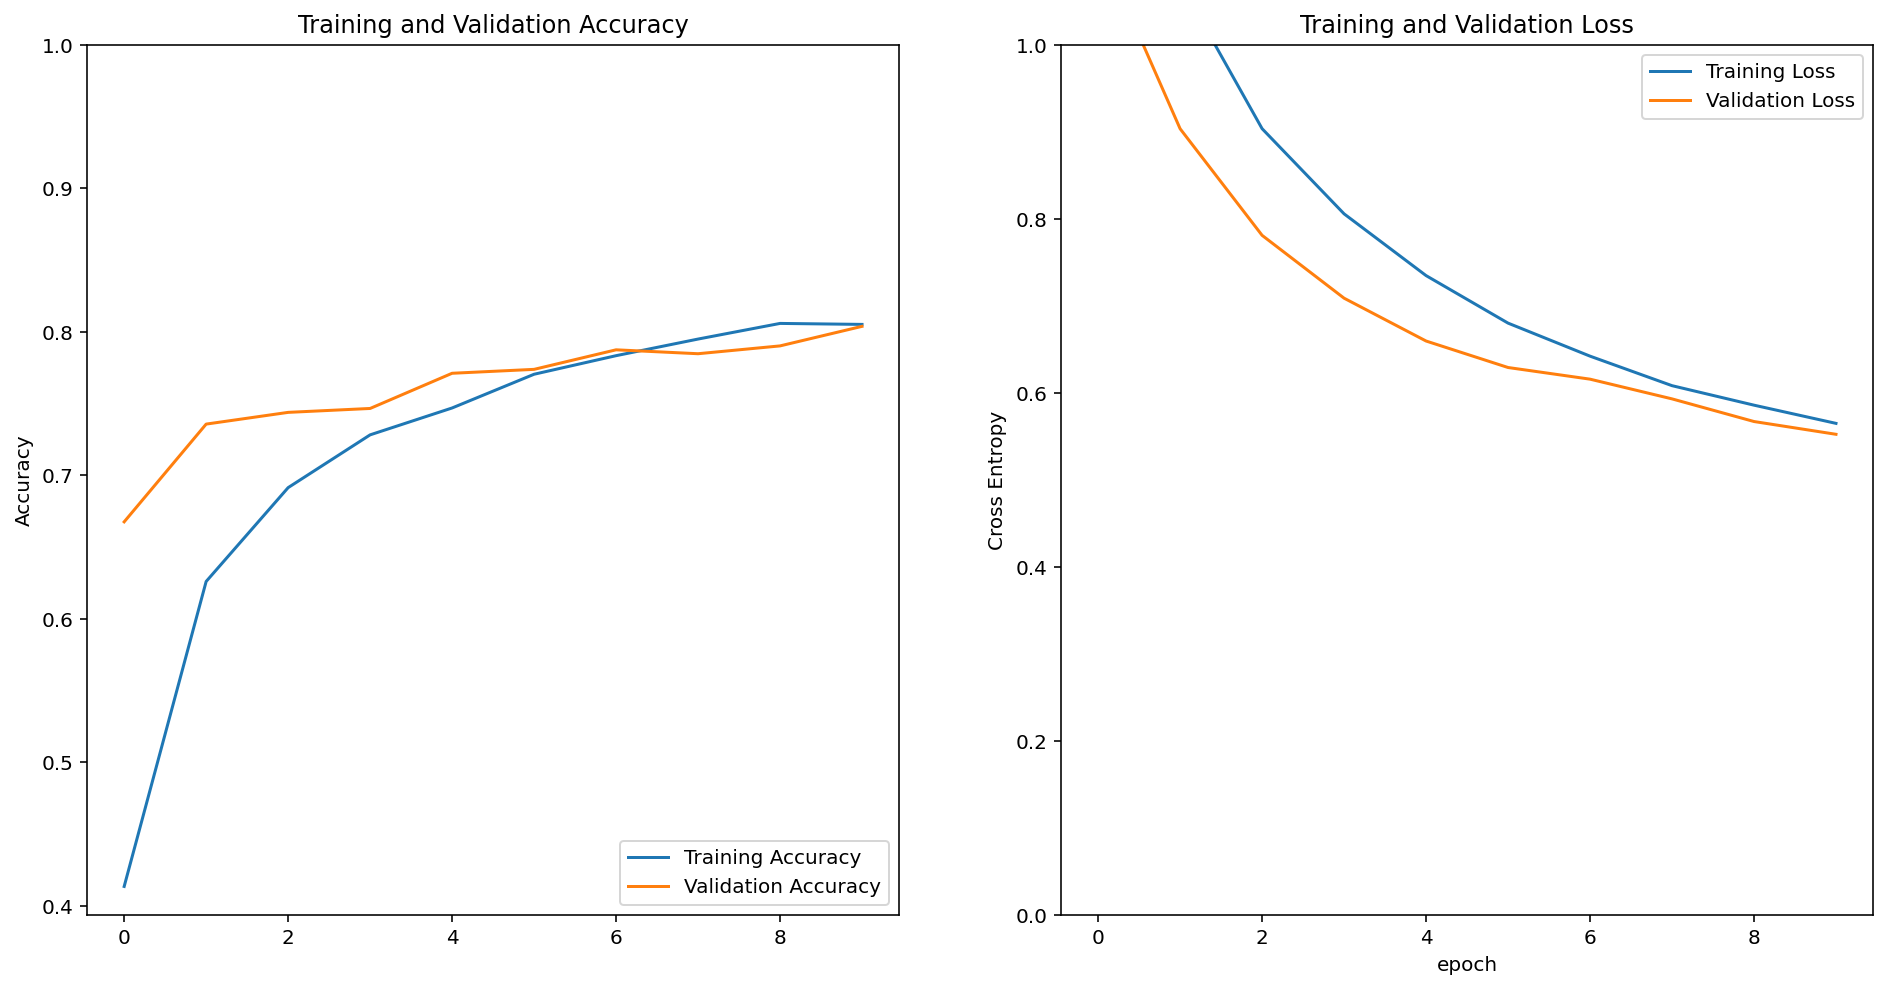

In [40]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
test_loss, test_acc = model.evaluate(raw_test, verbose=2)
## 어..? 오류가 나네 -> test, validation도 결과 점검 해보고 싶었는데, 추후에 시간이 된다면 보완해보고 싶당
#  ValueError: Input 0 is incompatible with layer sequential_1: expected shape=(None, 160, 160, 3), found shape=(None, None, 3)

ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1330 test_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1313 run_step  **
        outputs = model.test_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1267 test_step
        y_pred = self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer sequential_1: expected shape=(None, 160, 160, 3), found shape=(None, None, 3)


# Step 6. 모델 활용하기

모델이 꽤나 똑똑해졌다면, 이제 활용해볼 수 있습니다.

원하는 이미지를 자유롭게 모델에 입력해 보고, 어떤 예측 결과를 내는지 확인해 보세요!

In [45]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # 모델에 맞는 배치 차원 추가

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    class_names = ds_info.features['label'].names
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)
    
    print(f"This image most likely belongs to {predicted_class} with a {confidence:.2f} percent confidence.")

# 예시 이미지에 대한 예측 수행
predict_image('path_to_your_image.jpg', model)

## 양식은 chatgpt로 긁어오긴 했는데..

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_your_image.jpg'

In [ ]:
## 이 부분은 시간 관계상 개선하지 못했어요 ㅠㅠㅠ
## 추후에 사진을 실행시켜 보면서 대조해보는 과정도 추가해보고 싶다.
## 무슨 꽃인지 확인하는 과정을 생략하고 모델 생성에 급급했던 것 같다.